In [15]:
import json
import sys
import os
import gzip 
import logging
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("../../")

from didgelab.calc.geo import Geo, geotools
import didgelab.calc.fft
from didgelab.calc.sim.sim import *
from didgelab.calc.fft import *
from didgelab.calc.conv import *
from didgelab.util.didge_visualizer import vis_didge


In [6]:

# a node in the parent / children hierarchy of evolution_operations.jsonl.gz
class Node:

    def __init__(self, genome_id, losses, generation):
        self.genome_id = genome_id
        self.losses = losses
        self.generation = generation
        self.children = []
        self.parents = []

    def add_child(self, child_node, edge_name, edge_params):
        con = Edge(edge_name, edge_params, self, child_node)
        self.children.append(con)

    def add_parent(self, parent_node, edge_name, edge_params):
        con = Edge(edge_name, edge_params, parent_node, self)
        self.parents.append(con)

# an edge in the parent / children hierarchy of evolution_operations.jsonl.gz
class Edge:

    def __init__(self, name, params, parent, child):
        self.name = name
        self.params = params
        self.parent = parent
        self.child = child

class Nodes:

    def __init__(self):
        self.nodes = {}

    def add_node(self, node):
        self.nodes[node.genome_id] = node

    def has_node_id(self, node_id):
        return node_id in self.nodes.keys()

    def get_node(self, node_id):
        return self.nodes[node_id]
    
    def get_generation(self, i_generation):
        return list(filter(lambda x:x.generation==i_generation, self.nodes.values()))

    def iterate_edges(self):
        for node in self.nodes.values():
            for edge in node.children:
                yield edge

    def iterate_nodes(self):
        for node in self.nodes.values():
            yield node

    def connect(self, nodeid_parent, nodeid_child, edge_name, edge_params):
        parent = self.get_node(nodeid_parent)
        child = self.get_node(nodeid_child)
        parent.add_child(child, edge_name, edge_params)
        child.add_parent(parent, edge_name, edge_params)

# build the parent / children hierarchy of evolution_operations.jsonl.gz
def build_graph(infile):
    generation_counter = 0
    nodes = Nodes()
    num_errors = 0
    for line in gzip.open(infile):
        try:
            data = json.loads(line)
        except Exception as e:
            num_errors += 1
            if num_errors >= 3:
                break
            logging.error(e)
            continue
        for i in range(len(data["genome_ids"])):

            losses = {key: data["losses"][key][i] for key in data["losses"].keys()}
            node = Node(
                data["genome_ids"][i], 
                losses,
                generation_counter
            )
            nodes.add_node(node)
        generation_counter += 1

        mo = data["mutations_operations"]
        if len(mo)>0:
            for i in range(len(mo["operation"])):
                father_id = mo["father_id"][i]
                child_id = mo["child_id"][i]

                if nodes.has_node_id(child_id) and nodes.has_node_id(father_id):
                    nodes.connect(
                        father_id,
                        child_id,
                        mo["operation"][i],
                        {}
                    )

        co = data["crossover_operations"]
        if len(co)>0:
            for i in range(len(co["operation"])):
                parent1 = co["parent1_genome"][i]
                parent2 = co["parent2_genome"][i]
                child_id = co["child_id"][i]
                if nodes.has_node_id(child_id) and nodes.has_node_id(parent1) and nodes.has_node_id(parent2):
                        nodes.connect(
                            parent1,
                            child_id,
                            co["operation"][i],
                            {}
                        )
                        nodes.connect(
                            parent2,
                            child_id,
                            co["operation"][i],
                            {}
                        )
    return nodes

infile = '../../../saved_evolutions/2024-04-20T11-50-54_evolve_tamaki3/evolution_operations.jsonl.gz'
nodes = build_graph(infile)


<AxesSubplot: xlabel='generation', ylabel='loss'>

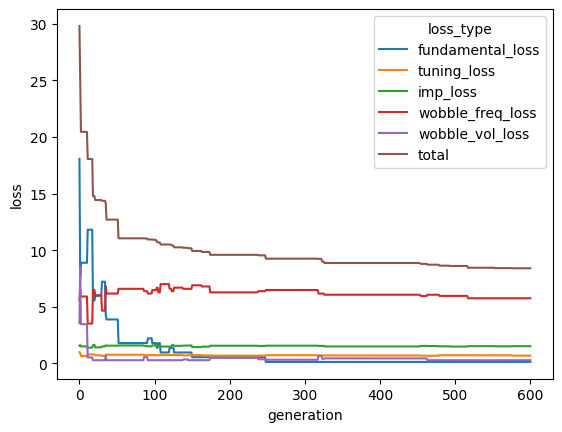

In [28]:
generations = {}
for node in nodes.iterate_nodes():
    if node.generation not in generations:
        generations[node.generation] = []
    generations[node.generation].append(node.losses)

indizes = sorted(generations.keys())
best_loss = None
losses = []
for i in indizes:

    besti = np.argmin([x["total"] for x in generations[i]])
    loss = generations[i][besti]

    if best_loss is None:
        best_loss = loss

    if loss["total"] < best_loss["total"]:
        best_loss = loss
    
    for key, value in best_loss.items():
        losses.append([i, key, value])

losses = pd.DataFrame(losses, columns=["generation", "loss_type", "loss"])
sns.lineplot(data=losses, x="generation", y="loss", hue="loss_type")


<AxesSubplot: xlabel='generation', ylabel='loss'>

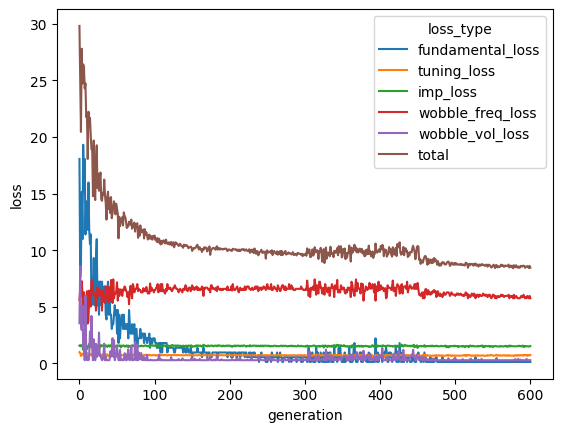

In [26]:
import seaborn as sns
sns.lineplot(data=losses, x="generation", y="loss", hue="loss_type")